In [2]:
import numpy as np
import emcee 
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

In [4]:
data = ascii.read('/Users/iraf1/Downloads/dd') # load data

## Section 1.1 - Quality Cuts
 - Remove NaN values [what age index are the nans]
 - $J_R$/$J_{R_{err}}$ > 20 ( or if this doesn't work -- parallax > 0.5 ) 
 - $J_R$ < 1500 -- looks like some stars have big action values that may be outliers
 - Dist > 0.5 (there seems to be an error with the distance estimate) 




## Section 1.2 - Population Cuts 
 - __Red Giants__: $log(g)$ < 3.8 dex 
 - __Main Sequence__: $log(g)$ > 3.8 dex
 
 


notes: 
 - Jz <1 : will restrict us to the disk 

OR

 - |Z| < 2 : will restrict the search to disk stars


In [126]:
# Define variables from Astropy table 

feh = data['fe_h'] # metalicity 
e_feh = data['e_fe_h']
l, b = data['l'], data['b'] # coordinates in Galactic

jr = data['JR'] # radial action
jr_err = data['JR_err'] # radial action error 

log_g = data['logg_1']
teff = data['teff']
parallax = data['parallax']
log_age = data['log_age']
age = 10**(log_age)
dist = data['dist']
mass = data['mass'] # APOGEE
mu_l , mu_b = data['mu_l'], data['mu_b']
z, kmag, jmag, hmag = data['z'], data['kmag'], data['jmag'], data['hmag']
vr = data['vR']



# Quality cuts to ensure quality of data : NOTE parallax < 0.5 (2kpc limit!)
qc = np.where((jr/jr_err > 10) &(jr<1500) & (age>0.5) & (age != np.ma.core.MaskedConstant()) & (feh != np.ma.core.MaskedConstant()) & (jr != np.ma.core.MaskedConstant()))

feh, e_feh, l, b = feh[qc], e_feh[qc], l[qc], b[qc]
jr, jr_err, log_g, teff, parallax, log_age, dist, mass = jr[qc], jr_err[qc], log_g[qc], teff[qc], parallax[qc], log_age[qc], dist[qc], mass[qc]
mu_l, mu_b, age  = mu_l[qc], mu_b[qc], age[qc]
z, kmag, jmag, hmag = z[qc], kmag[qc], jmag[qc], hmag[qc]
vr = vr[qc]

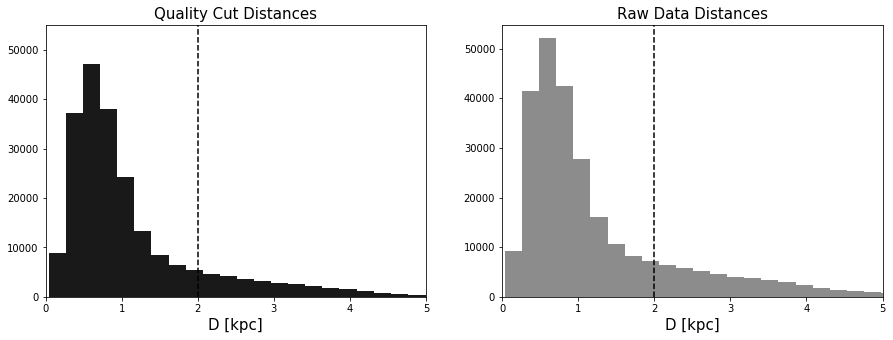

In [127]:
plt.figure(figsize=(15,11))
plt.subplot(221)
plt.hist(dist, bins=100, normed=False, color='k', alpha=0.9)
plt.xlim(0,5)
plt.ylim(0,55000)
plt.title('Quality Cut Distances', size=15)
plt.xlabel('D [kpc]', size=15)
plt.axvline(2, color='k', ls='--')

plt.subplot(222)
plt.hist(data['dist'], bins=100, normed=False, color='gray', alpha=0.9, ls='--', histtype='stepfilled')
plt.xlim(0,5)
plt.title('Raw Data Distances', size=15)
plt.xlabel('D [kpc]', size=15)
plt.axvline(2, color='k', ls='--')


/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()

Number of stars in MS cut: 157163
Number of stars in RG cut: 63353


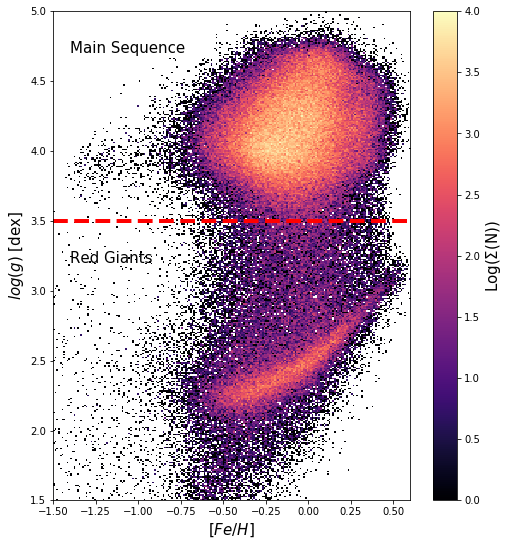

In [128]:
%config InlineBackend.figure_format = 'png'
cut_off = 3.5 # 3.8 sugggested by literatyre
# Apply population cuts
MS = np.where(log_g > cut_off)
RG = np.where(log_g < cut_off)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,9))

g_hist = np.histogram2d(log_g, feh, bins=(np.arange(1.5,5,0.01), np.arange(-1.5, 0.6, 0.01)))

Z = ax.imshow(np.log(g_hist[0]), aspect='auto', origin='lower', interpolation='nearest',
            extent=[-1.5, 0.6, 1.5, 5], cmap='magma', vmin=0, vmax=4)
ax.axhline(cut_off, color='red', ls='--', lw=4)

ax.text(-1.4,3.2, 'Red Giants', size=15, color='k' )
ax.text(-1.4,4.7, 'Main Sequence', size=15, color='k' )

ax.set_xlabel('$[Fe/H]$', size=15)
ax.set_ylabel('$log(g)$ [dex]', size=15)
cbar = fig.colorbar(Z, )#, label='$Log(\Sigma(N))$')
cbar.ax.set_ylabel('Log($\Sigma$(N))', fontsize=15, )

print ("Number of stars in MS cut: %d" %len(MS[0]))
print ("Number of stars in RG cut: %d" %len(RG[0]))


/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  



Text(0,0.5,'$j_{mag}$ - 5$log_{10}$(d)+5')

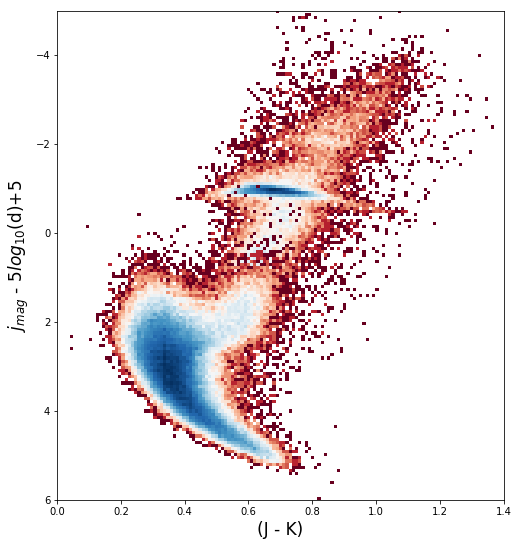

In [80]:
color = jmag - kmag
# calculate absolute magniude in jmag 
abs_mag_j = jmag - 5*np.log10(dist*1000) + 5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,9))
color_hist = np.histogram2d(abs_mag_j[MS], color[MS],
                           bins=(np.arange(-5, 6, 0.07), np.arange(0, 1.4, 0.01)))
color_hist2 = np.histogram2d(abs_mag_j[RG], color[RG],
                           bins=(np.arange(-5, 6, 0.07), np.arange(0, 1.4, 0.01)))


ax.imshow(np.log(color_hist2[0]), aspect='auto', interpolation='nearest',
          extent=[0, 1.4, 6, -5], cmap='RdBu')
ax.imshow(np.log(color_hist[0]), aspect='auto', interpolation='nearest',
          extent=[0, 1.4, 6, -5], cmap='RdBu')
ax.set_xlabel('(J - K)', size=17)
ax.set_ylabel('$j_{mag}$ - 5$log_{10}$(d)+5', size=17)



/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



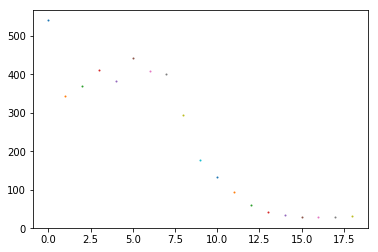

In [262]:

# Bin with error 
scanner = np.linspace(np.min(feh[RG]), np.max(feh[RG]), 20)

for i in range (0,len(scanner)-1):
    finder = np.where((feh[RG]>scanner[i]) & (feh[RG]<scanner[i+1]))
    
    err_bin = np.std((jr[RG])[finder])/np.sqrt(len((feh[RG])[finder]))
    med_val = np.median((jr[RG])[finder])
    med_age = np.median((age[RG])[finder])
    
    plt.scatter(i, med_val, s=1)

    #plt.errorbar(i,med_val, yerr=err_bin, capsize=12, fmt='none', color='k')




Text(0.5,1,'Red Giants')

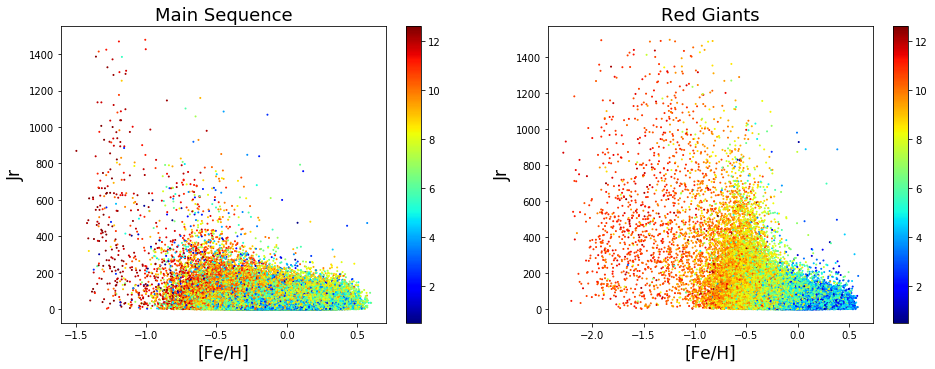

In [92]:
plt.figure(figsize=(16,12))

plt.subplot(221)
plt.scatter(feh[MS], jr[MS],c=age[MS], s=1, alpha=1, cmap='jet')
#plt.ylim(0,250)
#plt.xlim(-0.65)
plt.xlabel('[Fe/H]', size=17)
plt.ylabel('Jr', size=17)
plt.colorbar()
plt.title('Main Sequence', size=18)

plt.subplot(222)
plt.scatter(feh[RG], jr[RG],c=age[RG], s=1, alpha=1, cmap='jet')
#plt.ylim(0,450)
#plt.xlim(-0.65)
plt.xlabel('[Fe/H]', size=17)
plt.ylabel('Jr', size=17)
plt.colorbar()
plt.title('Red Giants', size=18)



In [94]:

df_ms  = stats.binned_statistic_2d(jr[MS], feh[MS], age[MS], statistic='median',
                                   bins=(np.arange(0, 600, 25), np.arange(-1, 0.6, 0.1)))

df_rg  = stats.binned_statistic_2d(jr[RG], feh[RG], age[RG], statistic='median',
                              bins=(np.arange(0, 800, 25), np.arange(-1.5, 0.6, 0.1)))

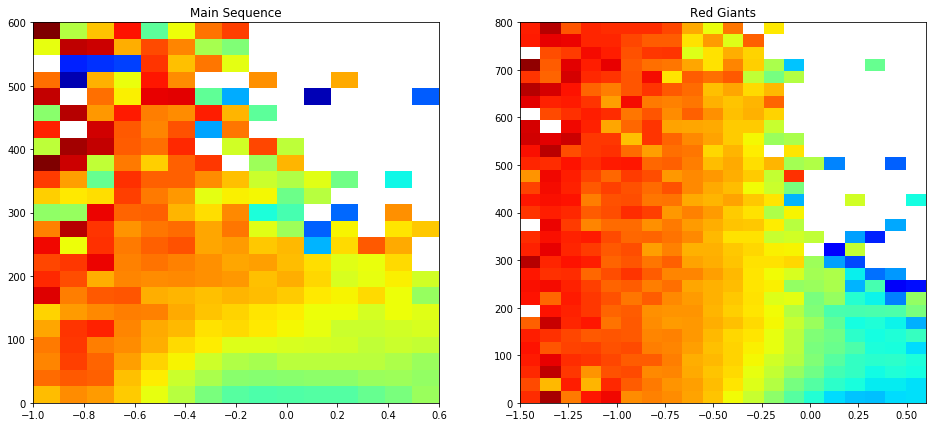

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

ax2 = ax[0].imshow((df_ms[0]), aspect='auto', origin='lower', cmap='jet',
          vmin=0, vmax=12, extent=[-1, 0.6, 0, 600])
ax[0].set_title('Main Sequence')


ax1 =  ax[1].imshow((df_rg[0]), aspect='auto', origin='lower', cmap='jet',
          vmin=0, vmax=12, extent=[-1.5, 0.6, 0, 800])
ax[1].set_title('Red Giants')

A = np.array([ax1, ax2])



/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)



Text(0.5,0,'[Fe/H]')

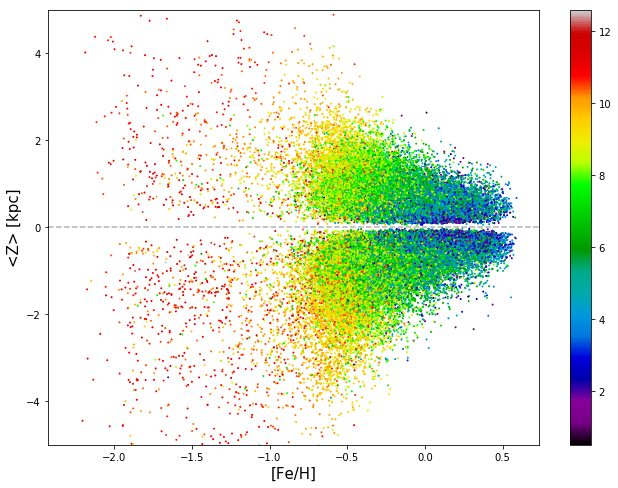

In [96]:
plt.figure(figsize=(11,8))
plt.scatter(feh[RG], z[RG], c=age[RG], cmap='spectral', s=1)
plt.colorbar()
plt.ylim(-5,5)
plt.axhline(0, color='k', ls='--', alpha=0.3)
plt.ylabel('<Z> [kpc]', size=15)
plt.xlabel('[Fe/H]', size=15)

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'[Fe/H]')

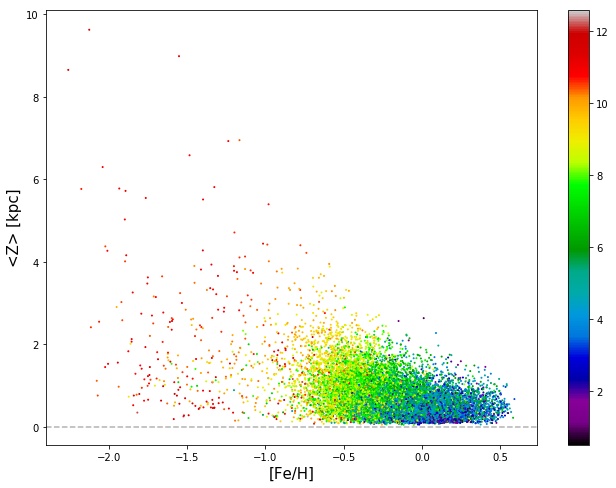

In [13]:
plt.figure(figsize=(11,8))
plt.scatter((feh[RG])[z[RG]>0], (z[RG])[z[RG]>0], c=(age[RG])[z[RG]>0], cmap='spectral', s=1)
plt.colorbar()
#plt.ylim(-5,5)
plt.axhline(0, color='k', ls='--', alpha=0.3)
plt.ylabel('<Z> [kpc]', size=15)
plt.xlabel('[Fe/H]', size=15)

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'[Fe/H]')

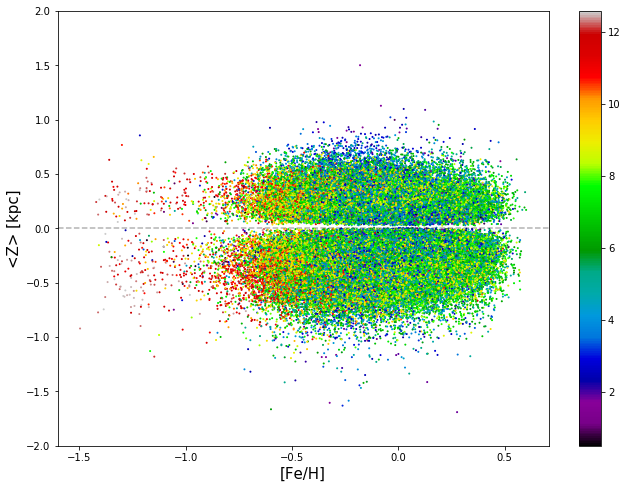

In [15]:
plt.figure(figsize=(11,8))
plt.scatter(feh[MS], z[MS], c=age[MS], cmap='spectral', s=1)
plt.colorbar()
plt.ylim(-2,2)
plt.axhline(0, color='k', ls='--', alpha=0.3)
plt.ylabel('<Z> [kpc]', size=15)
plt.xlabel('[Fe/H]', size=15)

In [140]:
# More physical cuts: 
from  galpy.util import bovy_coords
xyz = bovy_coords.lbd_to_XYZ(l[RG], b[RG],dist[RG] )
zf = bovy_coords.lbd_to_XYZ(l[MS], b[MS],dist[MS] )

vv = bovy_coords.vrpmllpmbb_to_vxvyvz(vr[RG], mu_l[RG], mu_b[RG], l[RG], b[RG], dist[RG])

In [161]:
xr = xyz[:,0]
zr = xyz[:,2]

In [209]:
phy  = stats.binned_statistic_2d((xyz[:,2]), (xyz[:,0]), age[RG], statistic='median',
                                 bins=(np.arange(-5, 5, 0.07), np.arange(-5, 5, 0.07)))

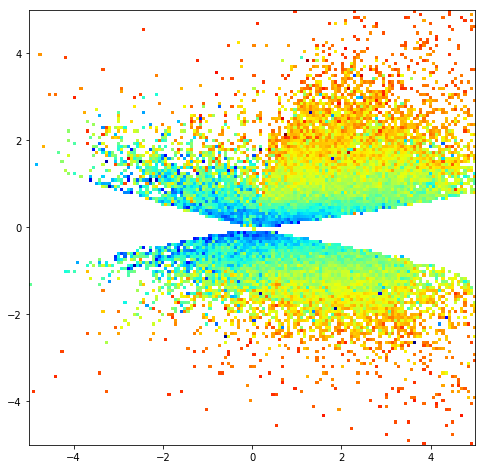

In [210]:
plt.figure(figsize=(8,8))
plt.imshow(phy[0], cmap='jet',interpolation='nearest', extent=[-5,5,-5,5],
          aspect='auto' )


/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)



Text(0.5,1,'Age: Red Giants')

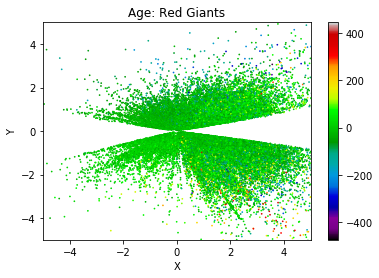

In [143]:
plt.scatter(xyz[:,0], xyz[:,2], s=0.5, c=(vv[:,2]), cmap='spectral')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Age: Red Giants')

Text(0.5,1,'Age: Red Giants')

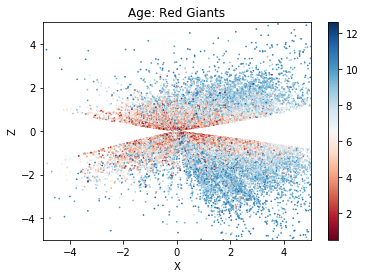

In [135]:
plt.scatter(xyz[:,0], xyz[:,2], s=0.5, c=age[RG], cmap='RdBu')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Age: Red Giants')

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)



Text(0.5,1,'Age: Main Sequence')

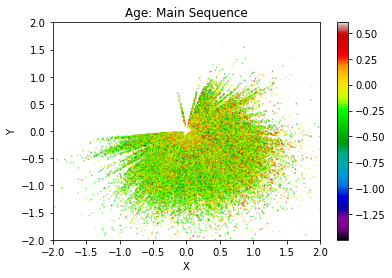

In [114]:
plt.scatter(zf[:,0], zf[:,1], s=0.1, c=feh[MS], cmap='spectral')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Age: Main Sequence')

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)



Text(0.5,1,'Age: Main Sequence')

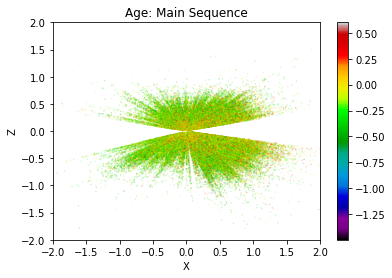

In [113]:
plt.scatter(zf[:,0], zf[:,2], s=0.01, c=feh[MS], cmap='spectral')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Age: Main Sequence')

Text(0.5,1,'Red Giant: Ages')

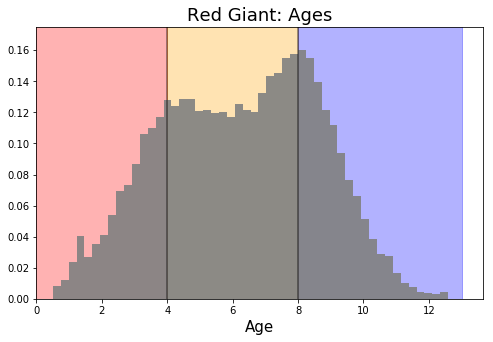

In [107]:
plt.figure(figsize=(8,5))
plt.hist(np.sort(age[RG]), bins=50, normed=True, histtype='stepfilled', color='gray',
        alpha=0.9)
plt.xlabel('Age', size=15)
plt.axvline(4, color='k', alpha=0.5)
plt.fill_between([4,0], [5900,5900], color='red', alpha=0.3)
plt.fill_between([4,8], [5900,5900], color='orange', alpha=0.3)
plt.fill_between([8,13], [5900,5900], color='blue', alpha=0.3)
plt.axvline(8, color='k', alpha=0.5)
plt.ylim(0, 0.175)
plt.xlim(0)
plt.title('Red Giant: Ages', size=18)

test


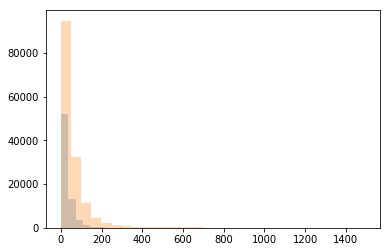

In [155]:
plt.hist(jr[age<5], bins=30, alpha=0.3)
plt.hist(jr[age>5], bins=30, alpha=0.3)
#plt.xlim(0,200)
print ('test')


<Container object of 3 artists>

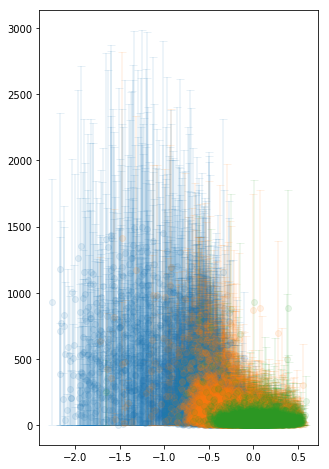

In [14]:
# Age restrictions: 

old_giants = np.where((age[RG] > 8) & (age[RG] < 12 ) )
young_giants = np.where((age[RG] > 4) & (age[RG] < 8 ) )
im = np.where((age[RG] > 0) & (age[RG] < 4 ) )

plt.figure(figsize=(5,8),)
plt.errorbar((feh[RG])[old_giants], (jr[RG])[old_giants], yerr=((jr[RG])[old_giants]), fmt='o', capsize=4,
            alpha=0.1)

plt.errorbar((feh[RG])[young_giants], (jr[RG])[young_giants], yerr=((jr[RG])[young_giants]), fmt='o', capsize=4,
            alpha=0.1)

plt.errorbar((feh[RG])[im], (jr[RG])[im], yerr=((jr[RG])[im]), fmt='o', capsize=4,
            alpha=0.1)

#plt.scatter((feh[RG])[young_giants], (jr[RG])[young_giants], s=0.5)
#plt.ylim(0,400)
#plt.xlim(-0.8)


When investigating the data in bins of distance, we notice that the the data seems to follow an exponential relationship with bins of age



$$\begin{equation}
model: \Gamma_{model} = \alpha e^{\beta x} + \gamma
\end{equation}$$


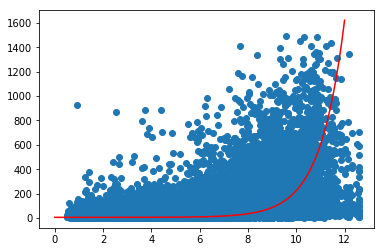

In [303]:
# plot the exponential before fitting:

plt.scatter(age[RG], jr[RG])
fake_age = np.linspace(0, 12, 100)
fake_model = 0.01*np.exp(0.9995*fake_age) + 5
plt.plot(fake_age,fake_model, color='red')




In [103]:
# Can we minimize chi2 
# chi2(model(guess in paramter space))

# a_random, b_random, c_random : gaussians pertubations
# append all chi2 estimates for each pertubation 
# append all fits of a,b,c 



In [210]:
# Define model 

def exp_model(alpha, beta, gamma, x_data):
    f1_term  = (beta*x_data)
    model = alpha * 10**(f1_term)  + gamma
    return (model)

def chi2_est(model, y_data, y_err):
    residual = (y_data - model) 
    return (np.sum(residual**2/y_err**2))

In [352]:
a_guess, b_guess, c_guess = [], [], []
N = 1000
X2 = []
for j in range (N):
    alpha_guess = np.random.normal(2.5,0.000001)
    beta_guess = np.random.normal(0.0001,0.2)
    gamma_guess = np.random.normal(5,0.1)
    
    guess_model = exp_model(alpha_guess, beta_guess, gamma_guess,
                            np.linspace(0,12,len(age[RG])))
    
    chi2 = chi2_est(guess_model, jr[RG], jr_err[RG])
    X2.append(chi2)
    a_guess.append(alpha_guess)
    b_guess.append(beta_guess)
    c_guess.append(gamma_guess)
    

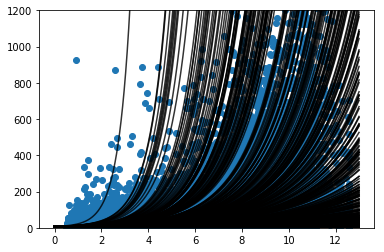

In [353]:
a_guess = np.array(a_guess)
b_guess = np.array(b_guess)
c_guess = np.array(c_guess)
t = np.linspace(0, 13, len(a_guess))


pi = 1000
for i in range (0, pi):
    m_e = exp_model(a_guess[i], b_guess[i], c_guess[i], t)

    plt.plot(t,m_e, color='k', alpha=0.8)
    #plt.xlim(11,12)
    plt.ylim(0,1200)
    if i==pi-1:
        plt.scatter(age[RG], jr[RG])


In [20]:
# MCMC analysis on RG data
import emcee
import corner

In [21]:
# Define lnlikelyhood! 

def lnprior(theta):
    alpha, beta, gamma = theta
    if 0 < alpha < 0.5  and 0 < beta < 1 and 0 < gamma < 250.0:
        return 0.0
    return -np.inf

def lnlike(theta, x, y, yerr):
    alpha, beta, gamma  = theta 
    f1_term  = (beta*x)
    model = alpha * 10**(f1_term)  + gamma

    residual = (y - model) 
    return -0.5*(np.sum(residual**2/yerr**2)) # estimate chi2 

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [22]:
ndim, nwalkers = 3, 200

In [60]:
initial_alpha = 0.01 # 15e8 old 
initial_beta = 1.01
initial_gamma = 10.5
n_steps = 1000 # Steps for Emcee

theta_init = [initial_alpha, initial_beta, initial_gamma]

# Normal perdubations to theta: 
theta_guess = np.zeros(shape=(nwalkers, ndim))
theta_guess[:, 0] = np.random.normal(theta_init[0], 0.01, nwalkers) 
theta_guess[:, 1] = np.random.normal(theta_init[1], 0.05, nwalkers)  # 10 was old 
theta_guess[:, 2] = np.random.normal(theta_init[2], 0.11, nwalkers)


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(age[RG], jr[RG],
                                                              np.random.normal(np.mean(jr_err[RG]),
                                                                               np.std(jr_err[RG]), len(age[RG]))))

In [61]:
sampler.run_mcmc(theta_guess, n_steps)

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[1.06174038e-02, 3.80941552e-01, 2.57846460e+01],
        [1.06176667e-02, 3.80941313e-01, 2.57844865e+01],
        [1.06158632e-02, 3.80947648e-01, 2.57850591e+01],
        [1.06163764e-02, 3.80945110e-01, 2.57850610e+01],
        [1.06172510e-02, 3.80942435e-01, 2.57846354e+01],
        [1.06162055e-02, 3.80945742e-01, 2.57851185e+01],
        [1.06184328e-02, 3.80937931e-01, 2.57842570e+01],
        [1.06177286e-02, 3.80940651e-01, 2.57844600e+01],
        [1.06168312e-02, 3.80943324e-01, 2.57848920e+01],
        [1.06172732e-02, 3.80941540e-01, 2.57848284e+01],
        [1.06172855e-02, 3.80941755e-01, 2.57848413e+01],
        [1.06170433e-02, 3.80943086e-01, 2.57848222e+01],
        [1.06173231e-02, 3.80942008e-01, 2.57846295e+01],
        [1.06166208e-02, 3.80944823e-01, 2.57847577e+01],
        [1.06169740e-02, 3.80943298e-01, 2.57847812e+01],
        [1.06178425e-02, 3.80940785e-01, 2.57843700e+01],
        [1.06160414e-02, 3.80946626e-01, 2.57850245e+01],
        [1.061

In [98]:
samples = sampler.chain[:,0:500, :].reshape((-1, ndim))

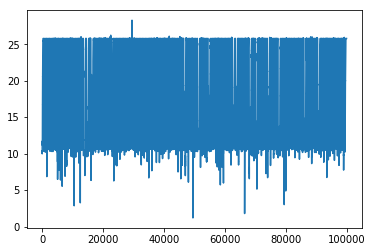

In [99]:
plt.plot(samples[:,2])

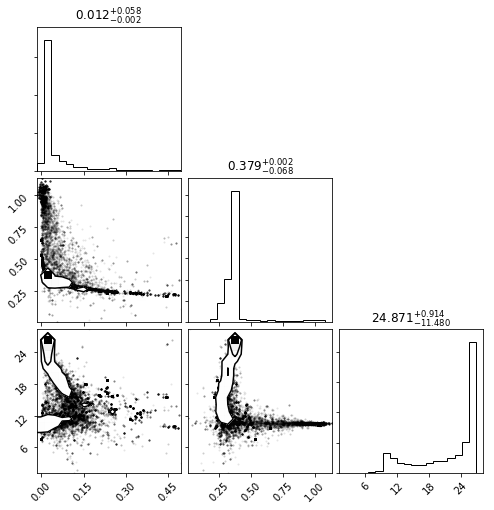

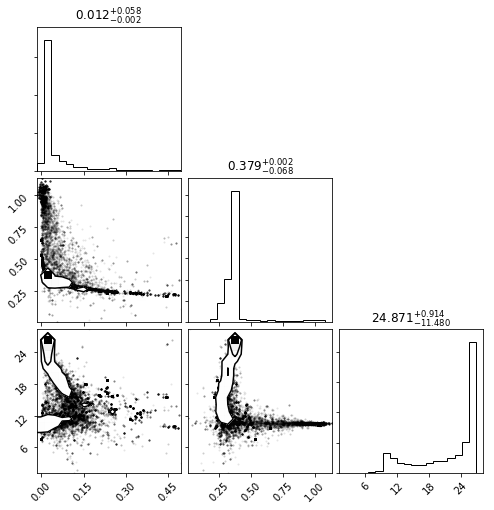

In [100]:
corner.corner(samples, show_titles=True,title_fmt='.3f')


/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


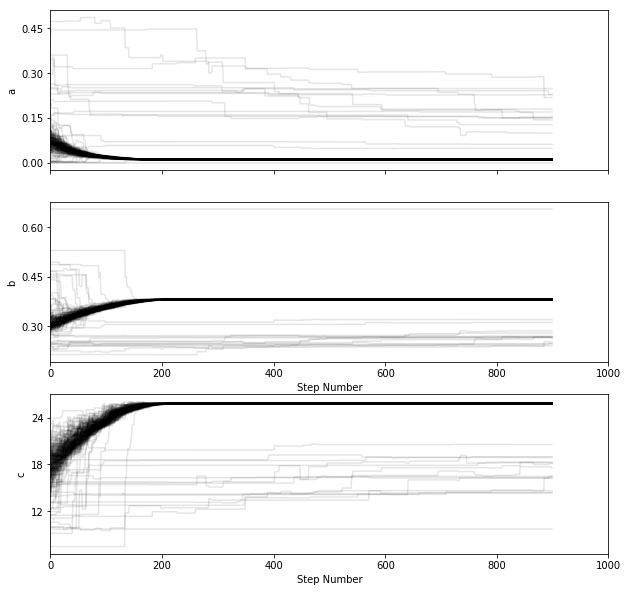

In [102]:
from matplotlib.ticker import MaxNLocator

Samples = sampler.chain
labels = ['a', 'b','c' ]

fig1 = plt.figure(figsize=[10, 10])

for i in range(Samples.shape[-1]):
    ax = fig1.add_subplot(3, 1, i + 1)
    ax.plot(sampler.chain[:, 100:, i].T, "k", alpha=0.1)
    ax.set_xlim(0, sampler.chain.shape[1])

    
    if i < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Step Number")
    ax.set_ylabel(labels[i])
    ax.yaxis.set_major_locator(MaxNLocator(4))
fig1.show()